# Ideal Diode Example

The simplest way to model a solar cell is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.params as byp
import deepdish as dd
from jupyterthemes import jtplot
#jtplot.style('solarizedd')
jtplot.style('default')

## List the parameters
First, we list our fitting parameters.

In [2]:
pl = byp.Param_list()
pl.add_fit_param(name='Bp',val_range=[10,1000],spacing='log',length=20,units='arb.')
pl.add_fit_param(name='n',val_range=[1,2],length=20, min_width=0.01)

Setting min_width automatically for Bp.


We can inspect the `Param_list` object and see what kind of information is inside...

In [3]:
print(pl)

{
    "fit_params": [
        {
            "units": "arb.", 
            "name": "Bp", 
            "spacing": "log", 
            "val_range": "[10, 1000]", 
            "vals": "[  11.22    14.125   17.783   22.387   28.184   35.481   44.67    56.2...", 
            "length": 20, 
            "edges": "[   10.       12.589    15.849    19.953    25.119    31.623    39.811...", 
            "min_width": 1.023292992280754, 
            "tolerance": 1.0023052380778996
        }, 
        {
            "units": "unitless", 
            "name": "n", 
            "tol_digits": 3, 
            "spacing": "linear", 
            "val_range": "[1, 2]", 
            "vals": "[1.025, 1.075, 1.125, 1.175, 1.225, 1.275, 1.325, 1.375, 1.425, 1.475,...", 
            "length": 20, 
            "edges": "[1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6...", 
            "min_width": 0.01, 
            "tolerance": 0.001
        }
    ], 
    "ec_x_name": null, 
    "ecs": [], 


Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the measurement conditions and output variable. We won't be varying light intensity here, so we only need voltage and temperature.

In [4]:
pl.add_ec(name='V', units='V', is_x=True) # this will be on the x-axis when we plot data
pl.add_ec(name='T', units='K', tolerance=0.1)
pl.add_output(name='J', units='A/cm^2')

In [5]:
print(pl)

{
    "fit_params": [
        {
            "units": "arb.", 
            "name": "Bp", 
            "spacing": "log", 
            "val_range": "[10, 1000]", 
            "vals": "[  11.22    14.125   17.783   22.387   28.184   35.481   44.67    56.2...", 
            "length": 20, 
            "edges": "[   10.       12.589    15.849    19.953    25.119    31.623    39.811...", 
            "min_width": 1.023292992280754, 
            "tolerance": 1.0023052380778996
        }, 
        {
            "units": "unitless", 
            "name": "n", 
            "tol_digits": 3, 
            "spacing": "linear", 
            "val_range": "[1, 2]", 
            "vals": "[1.025, 1.075, 1.125, 1.175, 1.225, 1.275, 1.325, 1.375, 1.425, 1.475,...", 
            "length": 20, 
            "edges": "[1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6...", 
            "min_width": 0.01, 
            "tolerance": 0.001
        }
    ], 
    "ec_x_name": "V", 
    "ecs": [
    

In [6]:
m = bym.Model(params=pl)

In [7]:
m.probs.points.head(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob
0,11.22,10.0,12.589,1.025,1.00,1.05,0.0025
1,11.22,10.0,12.589,1.075,1.05,1.10,0.0025
2,11.22,10.0,12.589,1.125,1.10,1.15,0.0025
3,11.22,10.0,12.589,1.175,1.15,1.20,0.0025
4,11.22,10.0,12.589,1.225,1.20,1.25,0.0025
5,11.22,10.0,12.589,1.275,1.25,1.30,0.0025
6,11.22,10.0,12.589,1.325,1.30,1.35,0.0025
7,11.22,10.0,12.589,1.375,1.35,1.40,0.0025
8,11.22,10.0,12.589,1.425,1.40,1.45,0.0025
9,11.22,10.0,12.589,1.475,1.45,1.50,0.0025


## Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.36$ and $B'=258$ as our "true" parameters. (I have no idea what "realistic" values for $B'$ would be...)

In [8]:
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

V = np.arange(0,1.0,0.01)
T = [float(t) for t in np.arange(150,301,50)]
#V = np.arange(0,1.0,0.1)
#T = [200.0,300.0]
params = {'n':1.36,'Bp':258}

data = []
for t in T:
    J0 = compute_ID({'V':V[0],'T':t},params)
    for v in V:
        J = compute_ID({'V':v,'T':t},params)
        if abs(J)>0.1:
            err = 0.05*abs(J)
        else:
            err = 0.005
        # check for "compliance"
        if not J > 2.0:
            data.append([v,t,J,err])
        
data = pd.DataFrame.from_records(data=data,columns=['V','T','J','error'])
dd.io.save('obs_data.h5',data)

In [9]:
m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.2, fixed_err=0.0001)

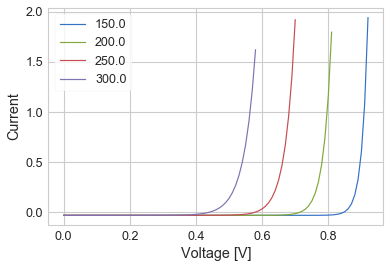

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
leg = []
for i in range(len(T)):
    curve = data[data['T']==T[i]]
    plt.plot(curve['V'],curve['J'])
    leg.append(curve['T'].iloc[0])
#plt.ylim([-0.05,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()

## Attach model
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [13]:
m.attach_model(mode='function',func_name=compute_ID)
#m.attach_model(mode='file',fpath='model_data.h5')

That's it! When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [14]:
m.calc_model_errors(verbose=True)

Calculating model errors...
Calculating model errors took 0.67 seconds.


## Drop that Bayes!
### First Bayes
rewrite explanation here

In [15]:
m.run()

Did a total of 36 runs to use a total of 41 observations.

An average of 217 / 400 probability points used model errors (rather than experimental errors) during this run.


We can visualize the distribution and add markers for the real values to compare...

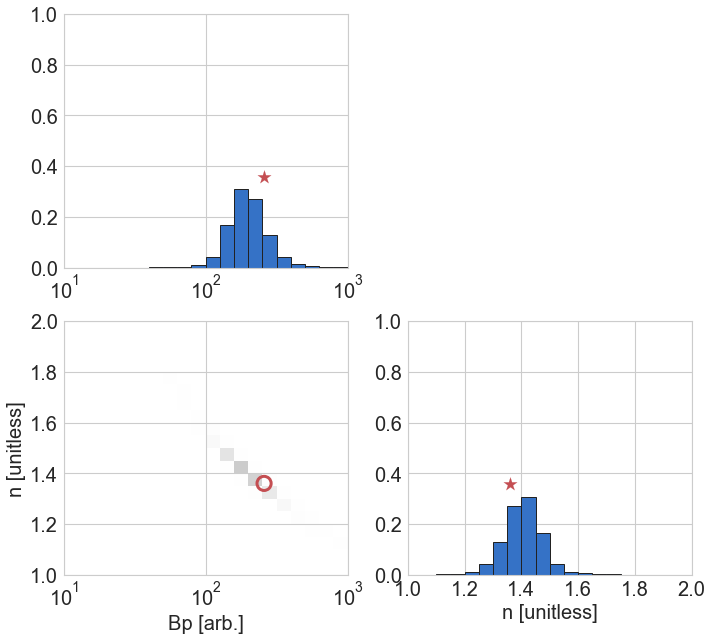

In [16]:
m.visualize_probs(true_vals=params)

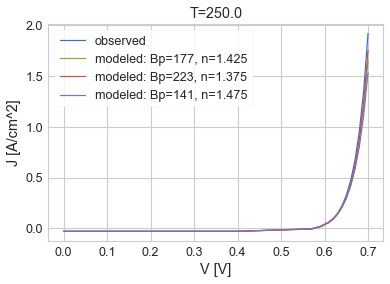

In [17]:
m.comparison_plot(num_param_pts=3)

Not too bad. We can also look at the probabilities directly.

In [18]:
m.probs.most_probable(5)

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob,start_ind,end_ind
248,177.83,158.49,199.53,1.425,1.40,1.45,0.302801,14632,14690
267,223.87,199.53,251.19,1.375,1.35,1.40,0.265233,15753,15811
229,141.25,125.89,158.49,1.475,1.45,1.50,0.160284,13511,13569
286,281.84,251.19,316.23,1.325,1.30,1.35,0.125481,16874,16932
305,354.81,316.23,398.11,1.275,1.25,1.30,0.038120,17995,18053


### Let's subdivide!
Again we'll use the default options, which will subdivide all grid boxes with probability > 0.001 as well as any immediately adjacent boxes.

In [ ]:
m.subdivide()

21 box(es) with probability > 0.001 and 26 neighboring boxes subdivided!
Overwriting metadata for fitting parameter Bp with new info.
Overwriting metadata for fitting parameter n with new info.


Let's take a look at the grid.

In [ ]:
m.visualize_grid(true_vals=params)

### Compute and attach new model data
We've added new model points to the grid so we have to compute the modeled values and attach that data.

In [ ]:
new_sims = dd.io.load('new_sim_points_1.h5')

In [ ]:
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.fit_param_names()])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.fit_param_names())
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_1.h5',new_sim_data)

In [ ]:
m.attach_model(mode='file', fpath='new_sim_data_1.h5', calc_errors=True)

### Second Bayes!
Let's do it again!

In [ ]:
m.run()
#m.run(force_exp_err=True,min_num_pts=1)

In [ ]:
m.visualize_probs(true_vals=params)

In [ ]:
m.probs.most_probable(10)

In [ ]:
m.comparison_plot(num_param_pts=3)

In [ ]:
m.subdivide()

In [ ]:
m.visualize_grid(true_vals=params)

In [ ]:
m.probs.points.sample(10)

In [ ]:
new_sims = dd.io.load('new_sim_points_2.h5')
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.fit_param_names()])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.fit_param_names())
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_2.h5',new_sim_data)
m.attach_model(mode='file', fpath='new_sim_data_2.h5', calc_errors=True)

In [ ]:
m.run()
#m.run(force_exp_err=True)

In [ ]:
m.visualize_probs(true_vals=params)

In [ ]:
m.probs.most_probable(5)

In [ ]:
m.model_data.sample(10)

In [ ]:
m.comparison_plot(num_param_pts=3, num_ecs=3)